In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import random
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, BatchNormalization, Conv2DTranspose, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

2025-10-14 17:55:05.360982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760464505.567389      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760464505.629032      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!nvidia-smi

Tue Oct 14 17:55:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import tensorflow as tf
print("GPUs detectadas:", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

GPUs detectadas: 1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    plt.show()

In [5]:
def plot_resultados(model, carpeta, height=64, width=64, n=4):
    """
    Muestra comparaciones entre imágenes originales y reconstruidas por el autoencoder.
    """
    # Seleccionar imágenes aleatorias
    archivos = os.listdir(carpeta)
    archivos_img = random.sample(archivos, n)

    # Cargar y normalizar las imágenes
    imgs_originales = []
    for nombre in archivos_img:
        img = load_img(os.path.join(carpeta, nombre), target_size=(height, width))
        img_array = img_to_array(img) / 255.0  # normalizar a [0,1]
        imgs_originales.append(img_array)

    imgs_originales = np.array(imgs_originales)

    # Reconstruir con el modelo
    imgs_reconstruidas = model.predict(imgs_originales)

    # Mostrar resultados
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs_originales[i])
        ax.set_title("Original")
        ax.axis("off")

        # Imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs_reconstruidas[i])
        ax.set_title("Reconstruida")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## Image analysis

We plot some of the images

In [6]:
# image_dir = '/kaggle/input/animefacedataset/images'

# # Load image file paths
# image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]

# # Read images and collect their shapes
# images = []
# shapes = []
# for file in image_files:
#     img = cv2.imread(file)
#     if img is not None:
#         images.append(img)
#         shapes.append(img.shape)

# # Check if all shapes are the same
# all_same_shape = all(shape == shapes[0] for shape in shapes)
# print("All images same shape:", all_same_shape)
# print("Image shape (height, width, channels):", shapes[0])

# # Plot the first 4 images
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# for i in range(min(4, len(images))):
#     img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
#     axs[i].imshow(img_rgb)
#     axs[i].axis('off')
#     axs[i].set_title(f'Image {i+1}')
# plt.tight_layout()
# plt.show()


In [7]:
# pd.Series(shapes).value_counts()

Shapes.value_counts()
```
(92, 92, 3)      1636
(96, 96, 3)      1556
(94, 94, 3)      1534
(95, 95, 3)      1530
(90, 90, 3)      1516
                 ... 
(87, 88, 3)         1
(220, 220, 3)       1
(126, 127, 3)       1
(101, 102, 3)       1
(181, 181, 3)       1
Name: count, Length: 181, dtype: int64
```

# Autoencoder

## Defining Hiperparameters

In [8]:
height, width = 64, 64 # Image size, to fit in the competition size
image_dir = '/kaggle/input/animefacedataset'
latent_dim=512

In [9]:
# Encoder
input_img = keras.Input(shape=(height, width, 3))
x_enc = Conv2D(16, (3, 3), strides=2, padding="same")(input_img)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(32, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(64, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(128, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(256, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
shape_before_flatten = keras.backend.int_shape(x_enc)[1:]
x_flat = Flatten()(x_enc)
encoded = Dense(latent_dim, name="latent_vector")(x_flat)

latent_input = keras.Input(shape=(latent_dim,))
x_dec = Dense(shape_before_flatten[0] * shape_before_flatten[1] * shape_before_flatten[2])(latent_input)
x_dec = Reshape(shape_before_flatten)(x_dec)
x_dec = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(16, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
decoded = Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x_dec)


encoder = Model(input_img, encoded, name="encoder")
decoder = Model(latent_input, decoded, name="decoder")


I0000 00:00:1760464518.159516      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


We define the autoencoder, encoder and decoder

In [10]:
input_img_ae = keras.Input(shape=(height, width, 3))
encoded_ae = encoder(input_img_ae)
decoded_ae = decoder(encoded_ae)

autoencoder = keras.Model(input_img_ae, decoded_ae, name="autoencoder")


In [11]:
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 512)            │       919,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 64, 3)      │     1,509,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,429,123 (9.27 MB)

 Trainable params: 2,427,139 (9.26 MB)

 Non-trainable params: 1,984 (7.75 KB)

## ImageDataGenerator

To fit with the competition, we will reshape images to 64x64

In [12]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create training and validation generators using the same seed
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),  
    batch_size=256,
    class_mode='input',
    subset='training',
    shuffle=True,
    seed=2004  
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),
    batch_size=256,
    class_mode='input',
    subset='validation',
    shuffle=False,
    seed=2004
)

Found 50852 images belonging to 1 classes.
Found 12713 images belonging to 1 classes.


## Train

In [13]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=opt, loss="mse")

In [14]:
# Fit the autoencoder
h = autoencoder.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1760464652.660020      58 service.cc:148] XLA service 0x7e78c4027960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760464652.660883      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760464653.753487      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/199 ━━━━━━━━━━━━━━━━━━━━ 1:03:09 19s/step - loss: 0.1371

I0000 00:00:1760464660.889971      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/199 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - loss: 0.0600 - val_loss: 0.0457
Epoch 2/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 64s 319ms/step - loss: 0.0286 - val_loss: 0.0282
Epoch 3/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 305ms/step - loss: 0.0225 - val_loss: 0.0241
Epoch 4/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 64s 322ms/step - loss: 0.0203 - val_loss: 0.0221
Epoch 5/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 308ms/step - loss: 0.0189 - val_loss: 0.0207
Epoch 6/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 67s 337ms/step - loss: 0.0179 - val_loss: 0.0195
Epoch 7/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 66s 333ms/step - loss: 0.0173 - val_loss: 0.0191
Epoch 8/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 67s 338ms/step - loss: 0.0166 - val_loss: 0.0184
Epoch 9/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 63s 315ms/step - loss: 0.0157 - val_loss: 0.0179
Epoch 10/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 63s 316ms/step - loss: 0.0152 - val_loss: 0.0164
Epoch 11/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 62s 313ms/step - loss: 0.0147 - val_loss: 0.0163
Epoch 12/40
199/199 ━━━━━━━━━━━━

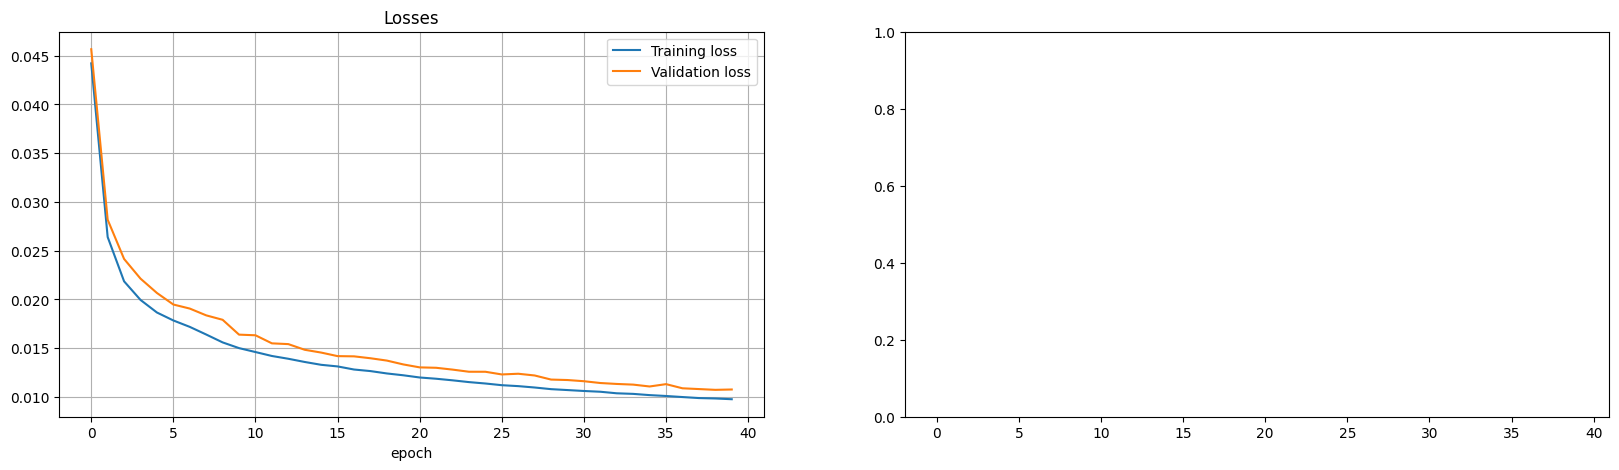

In [15]:
plot_losses(h.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


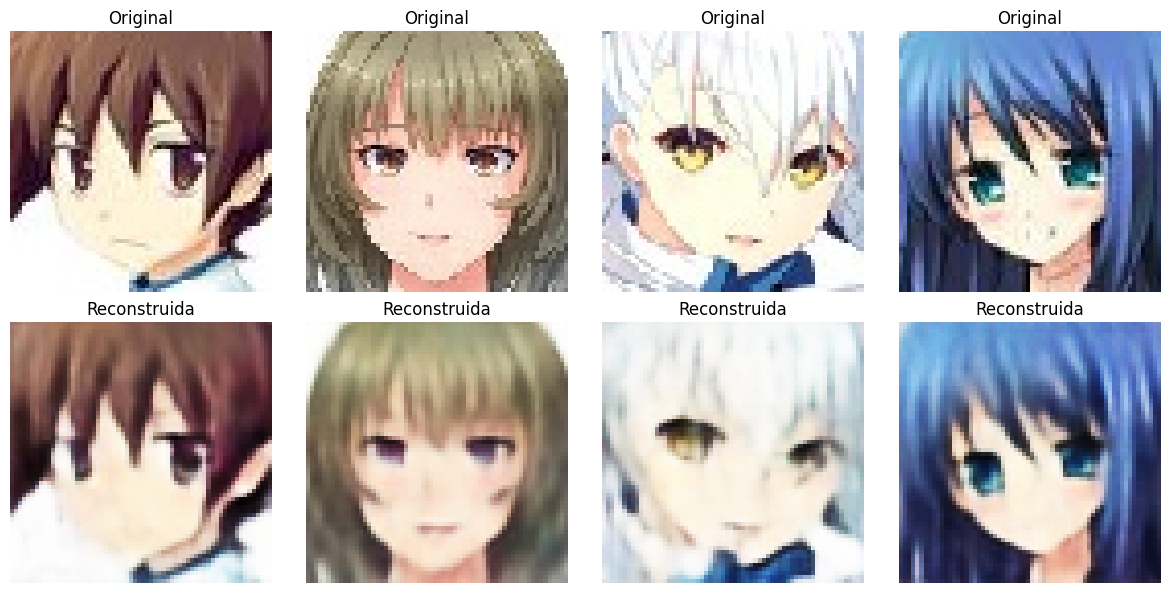

In [16]:
image_dir="/kaggle/input/animefacedataset/images"
plot_resultados(autoencoder,image_dir)

In [17]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)

model_path = f"models/autoencoder_v2_{timestamp}.keras"

# Save the model
autoencoder.save(model_path)
